This notebook contains an analyisis of suspect ages using visualizations and a permutation test.

In [1]:
%pip install tabula-py
%pip install tueplots


Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
from tueplots import bundles
from tueplots.constants.color import rgb
import math
import scipy.stats
import random

Between 2002 and 2013 the datasets were only available in PDF format, so in a preprocessing step we extracted the data to excel files. Also in these years there are fewer features for each offence category, so we read these files separately.

In [3]:
# Reading all cases between 2002 and 2013
cases = []
cases_col_names = ['Key', 'Offence', 'Recorded Cases', 'Recorded Cases Previous Year', 'Change in number', 'Change in %', 'CR% This Year']

for i in range(2,14):
  if(i<10):
    cases_in_this_year = pd.read_excel(f'Cases200{i}.xlsx', skiprows=0)
  else:
    cases_in_this_year = pd.read_excel(f'Cases20{i}.xlsx', skiprows=0)
  for j in range(len(cases_col_names)):
    cases_in_this_year.columns.array[j] = cases_col_names[j]
  to_drop = []
  i = 0
  for ind in cases_in_this_year.index:
    if cases_in_this_year['Key'].isnull()[i] == True:
        to_drop.append(i)
    i += 1
  cases_in_this_year = cases_in_this_year.drop(index=to_drop, axis=0)
  cases_in_this_year = cases_in_this_year.reset_index()
  cases_in_this_year = cases_in_this_year.drop(columns=['index'])

  cases.append(cases_in_this_year)
#cases[0]

In [4]:
# Reading all cases, suspects, victims, and developement files between 2014 and 2022
suspects = []
victims = []
developments = []

cases_col_names = ['Key', 'Offence', 'Recorded Cases', 'Percentage of All Cases', 'Attempts', 'Attempts in %', 'Inhabitants < 20k', '20k < Inhabitants < 100k', '100k < Inhabitants < 500k',
             'Inhabitants > 500k', 'Number of Inhabitants Unknown', 'Threatened with Firearm', 'Shot', 'Clearance', 'Clearance in %', 'Number of Suspects Recorded', 'Male Suspects',
             'Female Suspects', 'Number of Non-German Suspects', 'Non-German Suspects in %']
suspects_col_names = ['Key', 'Offence', 'Sex', 'Number of Suspects', 'Age < 6', '6 < Age < 8', '8 < Age < 10', '10 < Age < 12', '12 < Age < 14',
             'Age < 14', '14 < Age < 16', '16 < Age < 18', '14 < Age < 18', '18 < Age < 21', 'Age < 21', '21 < Age < 23', '23 < Age < 25',
             '21 < Age < 25', '25 < Age < 30', '30 < Age < 40', '40 < Age < 50', '50 < Age < 60', '60 < Age', '21 < Age']
victims_col_names = ['Key', 'Offence', 'Case status', 'Total', 'Male', 'Female', 'Total Age < 6', 'Male Age < 6', 'Female Age < 6',
                     'Total 6 < Age < 14', 'Male 6 < Age < 14', 'Female 6 < Age < 14', 'Total Age < 14', 'Male Age < 14', 'Female Age < 14',
                     'Total 14 < Age < 18', 'Male 14 < Age < 18', 'Female 14 < Age < 18', 'Total 18 < Age < 21', 'Male 18 < Age < 21', 'Female 18 < Age < 21',
                     'Total 21 < Age < 60', 'Male 21 < Age < 60', 'Female 21 < Age < 60', 'Total 60 < Age', 'Male 60 < Age', 'Female 60 < Age',
                     'Total 21 < Age', 'Male 21 < Age', 'Female 21 < Age']
developments_col_names = ['Change', 'Key', 'Offence', 'Recorded cases this year', 'Recorded cases previous year', 'Change number', 'Change in %', 'CR% this year',
                          'CR% previous year']

for i in range(14,23):
  cases_in_this_year = pd.read_excel(f'pks20{i}CasesBasicTable_excel.xlsx', skiprows=7)
  suspects_in_this_year = pd.read_excel(f'pks20{i}Suspects_excel.xlsx', skiprows=8)
  victims_in_this_year = pd.read_excel(f'pks20{i}Victims_excel.xlsx', skiprows=6)
  developments_in_this_year = pd.read_excel(f'pks20{i}CasesDevelopment_excel.xlsx', skiprows=17)

  for j in range(len(cases_col_names)):
    cases_in_this_year.columns.array[j] = cases_col_names[j]
  for j in range(len(suspects_col_names)):
    suspects_in_this_year.columns.array[j] = suspects_col_names[j]
  for j in range(len(victims_col_names)):
    victims_in_this_year.columns.array[j] = victims_col_names[j]
  for j in range(len(developments_col_names)):
    developments_in_this_year.columns.array[j] = developments_col_names[j]

  cases.append(cases_in_this_year)
  suspects.append(suspects_in_this_year)
  victims.append(victims_in_this_year)
  developments.append(developments_in_this_year)

We plot the ages of suspects to test if they are normally distributed, using the data from 2022.

In [5]:
# The list ages contains the age goups, denominators the size of the age groups

ages = ['Age < 6', '6 < Age < 8', '8 < Age < 10', '10 < Age < 12', '12 < Age < 14',
              '14 < Age < 16', '16 < Age < 18', '18 < Age < 21', '21 < Age < 23', '23 < Age < 25',
              '25 < Age < 30', '30 < Age < 40', '40 < Age < 50', '50 < Age < 60', '60 < Age']
suspects_22_by_ages = [suspects[8].loc[0].at[i] for i in ages]
denominators = [6,2,2,2,2,2,2,3,2,2,5,10,10,10,21]

In [6]:
mean_ages = [6,7,9,11,13,15,17,19.5,22,24,27.5,35,45,55,65] # Mean of every age group (we use 6 for the first group)
bottom_ages = [0,6,8,10,12,14,16,18,21,23,25,30,40,50,60] # Lower limit of each age group

mean_of_age_of_all_suspects = sum(i[0]*i[1] for i in zip(mean_ages,suspects_22_by_ages))/sum(suspects_22_by_ages)
var_of_age_of_all_suspects = sum(i[0]*i[1] for i in zip((mean_ages-mean_of_age_of_all_suspects)**2,suspects_22_by_ages))/(sum(suspects_22_by_ages)-1)
std_of_age_of_all_suspects = math.sqrt(var_of_age_of_all_suspects)

In [7]:
# Creating a datapoint for each suspect using their age group's mean

datapoints_ages = []
for i in range(len(mean_ages)):
  for j in range(suspects_22_by_ages[i]):
    datapoints_ages.append(mean_ages[i])

In [8]:
# Creating a datapoint for each suspect for kernel density estimation - in every age group the possible ages are uniformly distributed

datapoints_for_kde = []
for i in range(len(bottom_ages)):
  j = bottom_ages[i] + 1
  k = suspects_22_by_ages[i]
  while k > 0:
    datapoints_for_kde.append(j)
    k = k-1
    j = j+1
    if(j == bottom_ages[i] + denominators[i] + 1):
      j = bottom_ages[i] + 1

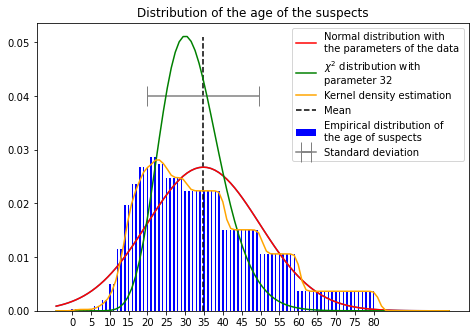

In [21]:
# Plotting the number of suspects grouped by age

# plt.rcParams.update(bundles.icml2022(column='half', nrows=2, ncols=1, usetex=False))

X = np.arange(len(ages))
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
plt.xticks(np.arange(0,81,5))
y_sparse = [i[0]/i[1] for i in zip(suspects_22_by_ages, denominators)]

y = []
for i in range(len(denominators)):
  for j in range(denominators[i]):
    y.append(y_sparse[i])


ax.bar(np.arange(81), y/sum(suspects_22_by_ages), color = 'blue', width = 0.4, label='Empirical distribution of \nthe age of suspects')
xmin, xmax = plt.xlim()
x_axis = np.linspace(xmin,100,100)

ax.plot(x_axis, scipy.stats.norm.pdf(x_axis, mean_of_age_of_all_suspects, std_of_age_of_all_suspects))
mu, std = scipy.stats.norm.fit(datapoints_ages)
ax.plot(x_axis, scipy.stats.norm.pdf(x_axis, mu, std), color = 'r', label = 'Normal distribution with \nthe parameters of the data')

ax.plot(x_axis, scipy.stats.chi2.pdf(x_axis, 32), color = 'g', label = '$\chi^2$ distribution with \nparameter 32')
ax.vlines(mu, 0, 0.051, linestyles='dashed', color = 'black', label = 'Mean')
ax.errorbar(mu, 0.04, None, std, capsize = 10, color = 'gray', label='Standard deviation')

kde = scipy.stats.gaussian_kde(datapoints_for_kde)
ax.plot(x_axis, kde.pdf(x_axis), color = 'orange', label='Kernel density estimation')
plt.title('Distribution of the age of the suspects')

ax.legend()

We create a heatmap to show which age group tends to commit most of each crime.

In [22]:
# Extract the suspects for every offence from 2022 grouped by ages 

offences_ages_matrix = suspects[8].iloc[5::3, 4:].drop(columns=['Age < 14', '14 < Age < 18', 'Age < 21', '21 < Age < 25', '21 < Age'])
numpy_matrix = offences_ages_matrix.to_numpy()

# Filter rows with at least one non-zero element
non_zero_rows = np.any(numpy_matrix != 0, axis=1)
numpy_matrix = numpy_matrix[non_zero_rows]

row_sums = numpy_matrix.sum(axis=1)
numpy_matrix = numpy_matrix/row_sums[:, np.newaxis]

Text(0, 0.5, 'Offences')

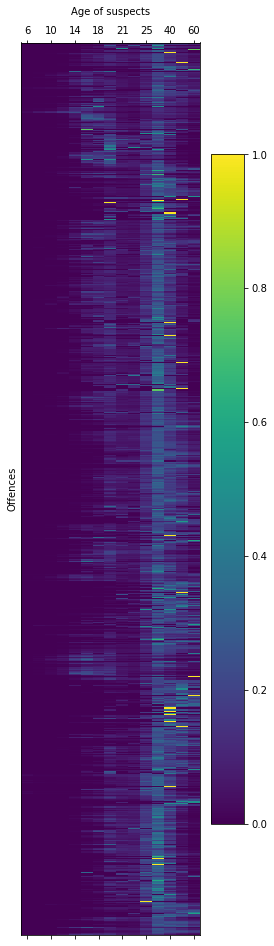

In [23]:
plt.matshow(numpy_matrix, aspect='auto', cmap='viridis')
plt.colorbar()
plt.xticks([0,2,4,6,8,10,12,14], [6,10,14,18,21,25,40,60])
plt.yticks([])
plt.xlabel('Age of suspects')
plt.gca().xaxis.set_label_coords(0.5, 1.04)
plt.ylabel('Offences')

Permutation test to check if the distribution of the number of suspects over the age groups is the same for males and females.

In [24]:
# We use the data from the year 2022. The sample's sizes are 1/1000 of the size of the actual number of suspects in order to be able to compute a sufficient number of permutations.
# As we do not know the exact ages of the suspects but we need them to calculate the test statistic, we use the mean of each age group.

# The total number of male and/or female suspects
total_males = suspects[-1].loc[0].at['Number of Suspects']
total_females = suspects[-1].loc[1].at['Number of Suspects']
total = total_males + total_females

lower_limits_ages = [4,6,8,10,12,14,16,18,21,23,25,30,40,50,60,80] # Lower limits of age groups

# Creating the samples: one contains the ages of male suspects, the other the ages of female suspects
male_ages = (lower_limits_ages[0]+lower_limits_ages[1])/2*np.ones(suspects[-1].loc[0].at['Age < 6']//1000)//1
female_ages = (lower_limits_ages[0]+lower_limits_ages[1])/2*np.ones(suspects[-1].loc[1].at['Age < 6']//1000)//1
index = 1
for k in range(1,len(ages)):
    male_ages = np.concatenate((male_ages, (lower_limits_ages[index]+lower_limits_ages[index+1])/2*np.ones(suspects[-1].loc[0].at[ages[k]]//1000)//1), axis=None)
    female_ages = np.concatenate((female_ages, (lower_limits_ages[index]+lower_limits_ages[index+1])/2*np.ones(suspects[-1].loc[1].at[ages[k]]//1000)//1), axis=None)
    index += 1

Y = np.concatenate((male_ages, female_ages), axis=None)
X = np.bool8(np.concatenate([np.ones(male_ages.size), np.zeros(female_ages.size)]))

# Creating B number of permutations
rng = np.random.default_rng(1)
B = 10**6
X_permuted = rng.permuted(np.tile(X, (B,1)), axis=1)

In [25]:
# Define the test statistic as the absolute difference of the means
def T_mean(group):
    return abs(np.mean(Y[~group]) - np.mean(Y[group]))

In [26]:
# Calculating the observed statistic value and the value of the statistic for all the permutations
mean_true = T_mean(X)
mean_dist = np.apply_along_axis(T_mean, 1, X_permuted)

In [29]:
# Calculating the p-value
cnt = 0
for element in mean_dist:
    if abs(element) > mean_true:
        cnt +=1
p_value = cnt/B
print(p_value)

0.15526


We also create a plot to visualize the distribution of the number of suspects over the age groups is the same for males and females each year.

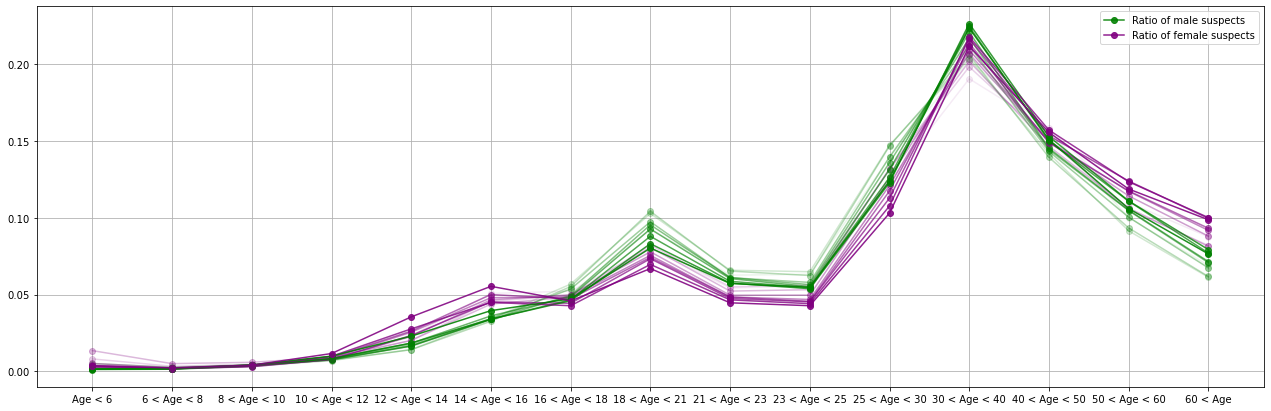

In [34]:
# Larger alpha values correspond to more recent years

plt.figure(figsize=(22,7))

for i in range(len(suspects)):
    mr = [suspects[i].loc[0].at[age]/suspects[i].loc[0].at['Number of Suspects'] for age in ages]
    fr = [suspects[i].loc[1].at[age]/suspects[i].loc[1].at['Number of Suspects'] for age in ages]
    if i != len(suspects)-1:
        plt.plot(ages, mr, 'o-', color='green', alpha=i/(len(suspects)+1)+0.08)
        plt.plot(ages, fr, 'o-', color='purple', alpha=i/(len(suspects)+1)+0.08)
    else:
        plt.plot(ages, mr, 'o-', color='green', alpha=i/(len(suspects)+1)+0.08, label='Ratio of male suspects')
        plt.plot(ages, fr, 'o-', color='purple', alpha=i/(len(suspects)+1)+0.08, label='Ratio of female suspects')

plt.legend()
plt.grid()
plt.show()